c:\Users\rosem\Documents\AJ\Thesis-Implementation\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully
SHAP version: 0.49.1
Data Loaded:
   Training samples: 888
   Test samples: 222
   Features: 16
   Feature names: 16

Found 7 ensemble models:
   - bagging_neural_network
   - bagging_random_forest
   - boosting_gradient_boost
   - stacking_neural_only
   - stacking_neural_ridge
   - stacking_neural_ridge_neural_final
   - stacking_neural_ridge_ridge_final
Loaded: BAGGING NEURAL NETWORK
Loaded: BAGGING RANDOM FOREST
Loaded: BOOSTING GRADIENT BOOST
Loaded: STACKING NEURAL ONLY
Loaded: STACKING NEURAL RIDGE
Loaded: STACKING NEURAL RIDGE NEURAL FINAL
Loaded: STACKING NEURAL RIDGE RIDGE FINAL

SHAP (SHAPLEY VALUES) FEATURE IMPORTANCE ANALYSIS - ENSEMBLE MODELS

Calculating SHAP values for all ensemble models...
This may take several minutes...

[BAGGING_NEURAL_NETWORK] Computing SHAP values...


100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


   SHAP computation complete for BAGGING_NEURAL_NETWORK

[BAGGING_RANDOM_FOREST] Computing SHAP values...
   SHAP computation complete for BAGGING_RANDOM_FOREST

[BOOSTING_GRADIENT_BOOST] Computing SHAP values...
   SHAP computation complete for BOOSTING_GRADIENT_BOOST

[STACKING_NEURAL_ONLY] Computing SHAP values...


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


   SHAP computation complete for STACKING_NEURAL_ONLY

[STACKING_NEURAL_RIDGE] Computing SHAP values...


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


   SHAP computation complete for STACKING_NEURAL_RIDGE

[STACKING_NEURAL_RIDGE_NEURAL_FINAL] Computing SHAP values...


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


   SHAP computation complete for STACKING_NEURAL_RIDGE_NEURAL_FINAL

[STACKING_NEURAL_RIDGE_RIDGE_FINAL] Computing SHAP values...


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


   SHAP computation complete for STACKING_NEURAL_RIDGE_RIDGE_FINAL

SHAP FEATURE IMPORTANCE RANKINGS

BAGGING NEURAL NETWORK - Top 10 Features by SHAP:
Rank  Feature                  SHAP Importance     
---------------------------------------------------
1     StudyHours               0.398069            
2     InternshipGrade          0.383587            
3     MotivationScore          0.362268            
4     EmploymentStatus         0.353362            
5     GPA                      0.349435            
6     IncomeLevel              0.344976            
7     EnglishProficiency       0.342976            
8     Age                      0.331276            
9     TestAnxiety              0.318384            
10    SleepHours               0.317911            

BAGGING RANDOM FOREST - Top 10 Features by SHAP:
Rank  Feature                  SHAP Importance     
---------------------------------------------------
1     StudyHours               0.374044            
2     TestAnxiety 

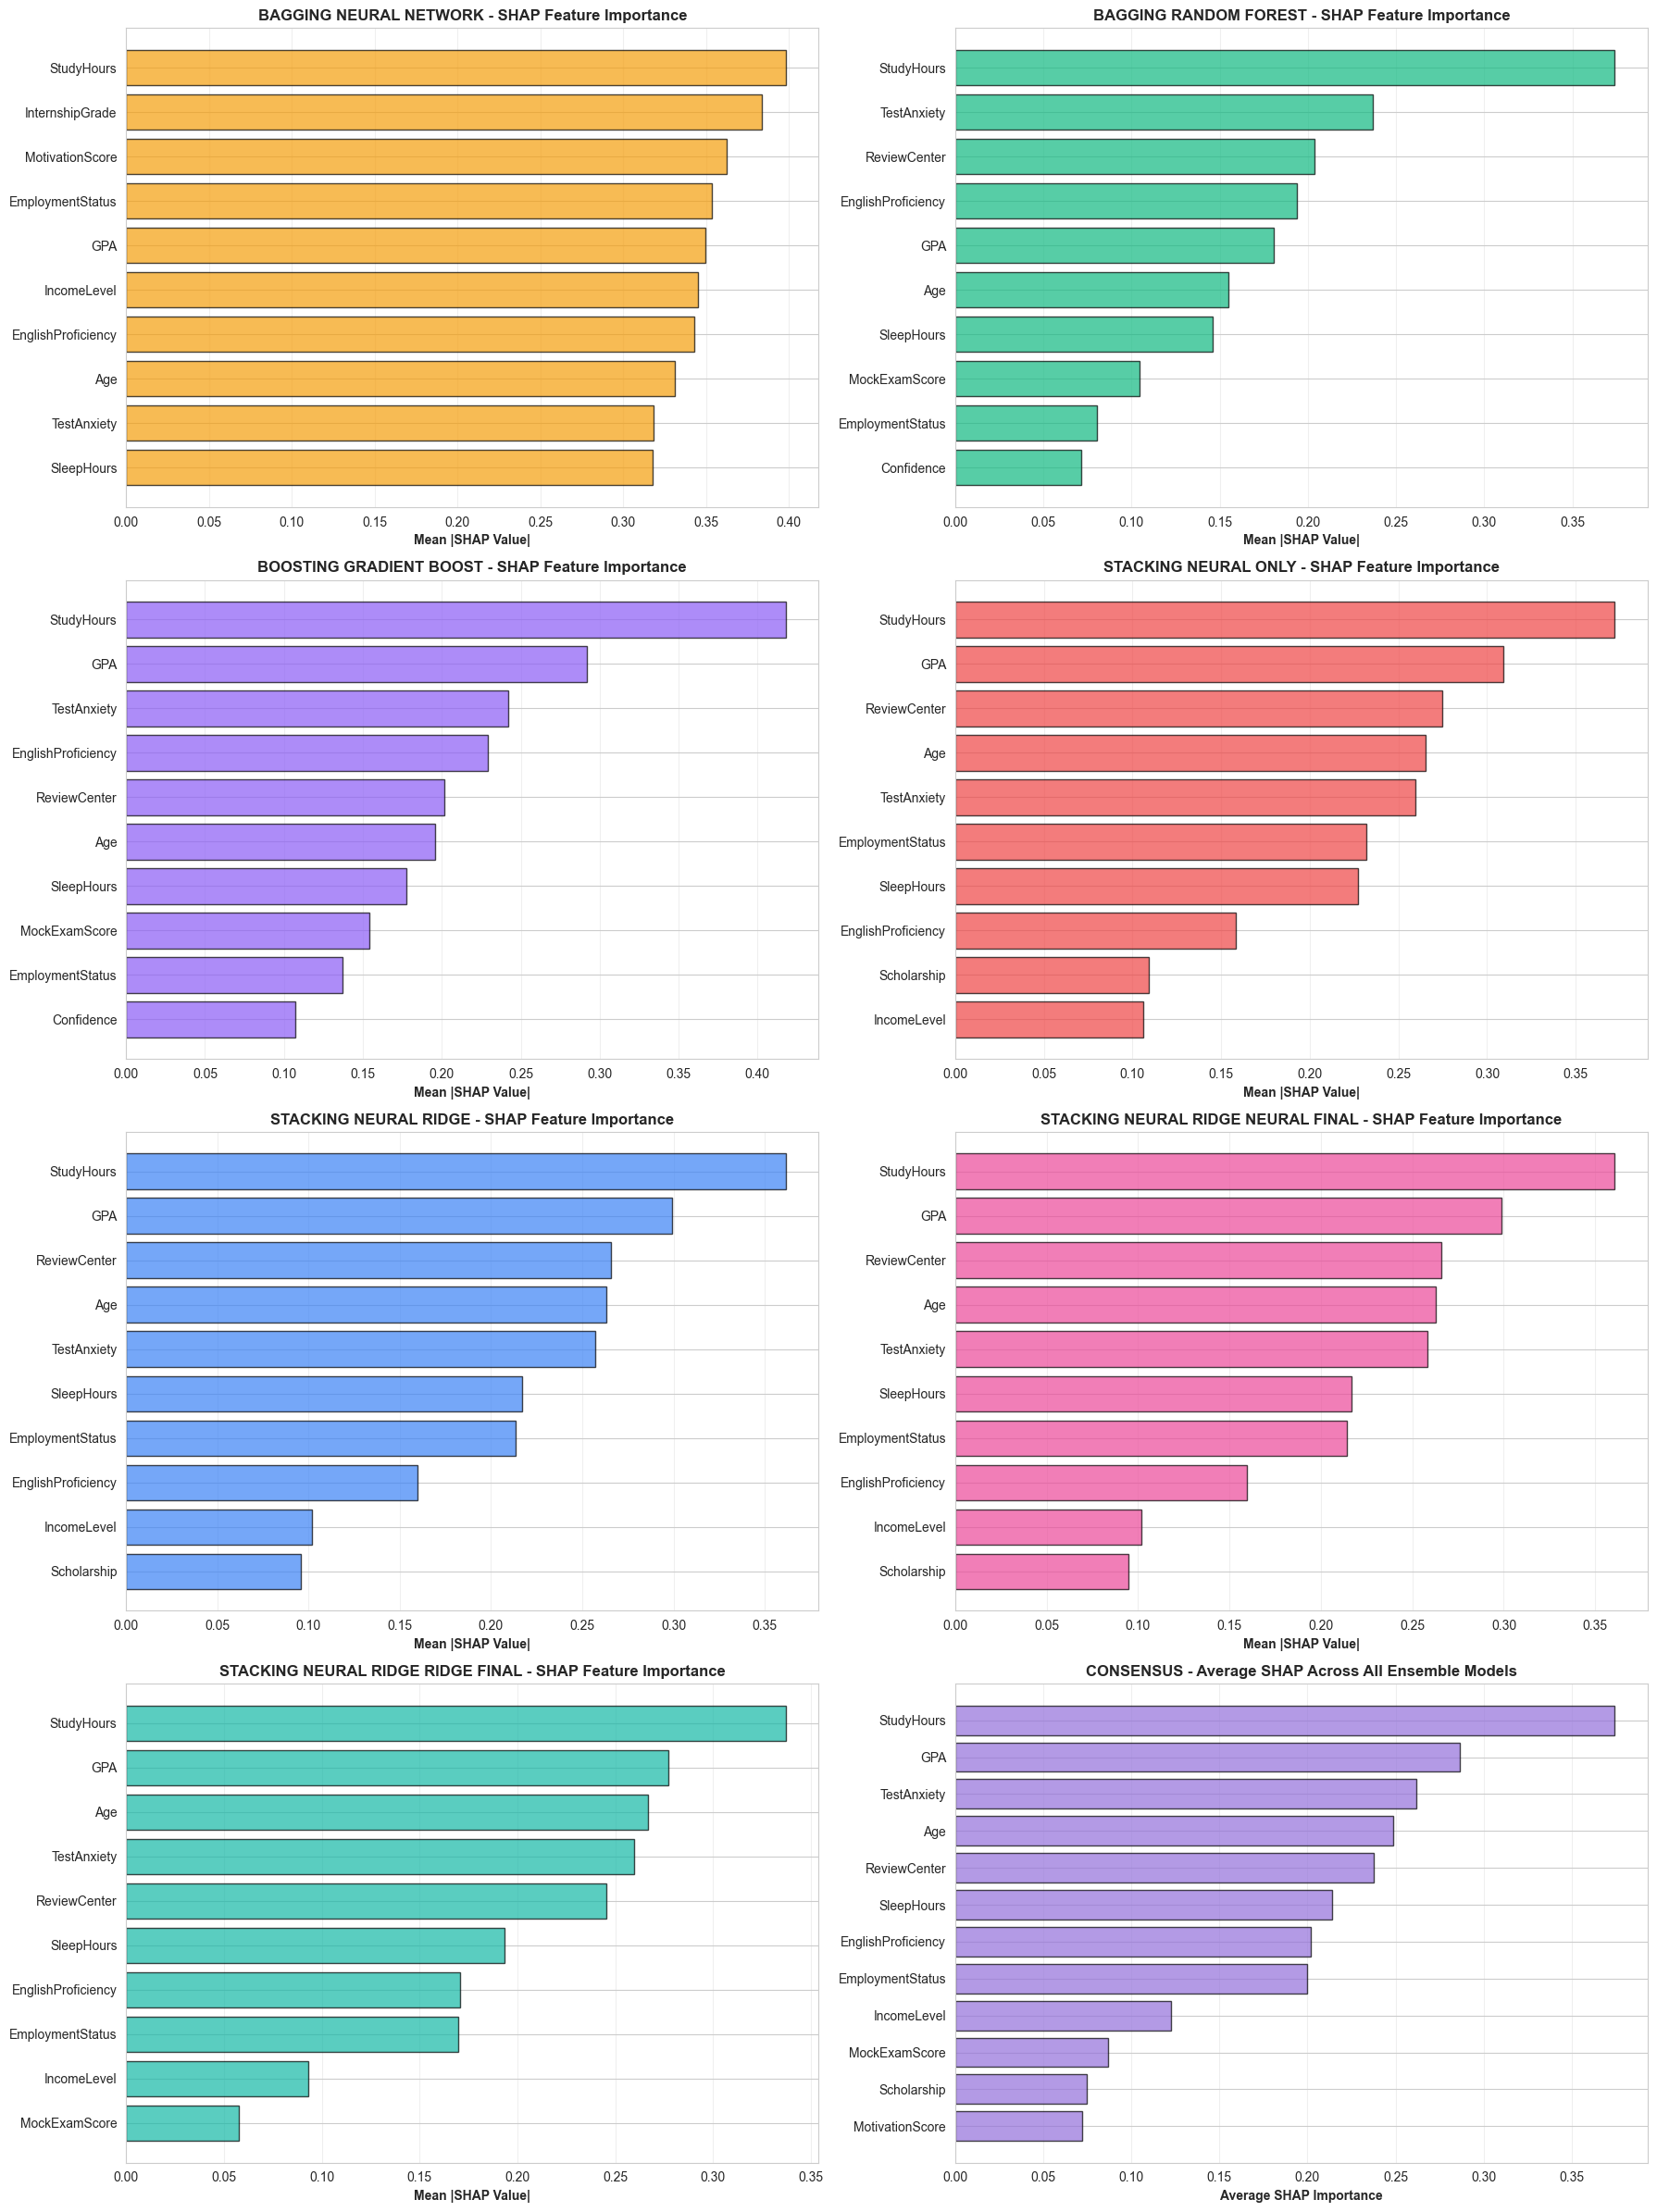


DETAILED SHAP PLOTS FOR BOOSTING_GRADIENT_BOOST

1. SHAP Summary Plot (Feature Impact Distribution)
Saved: ../saved_ensemble_models/shap_analysis/boosting_gradient_boost_summary_plot.png


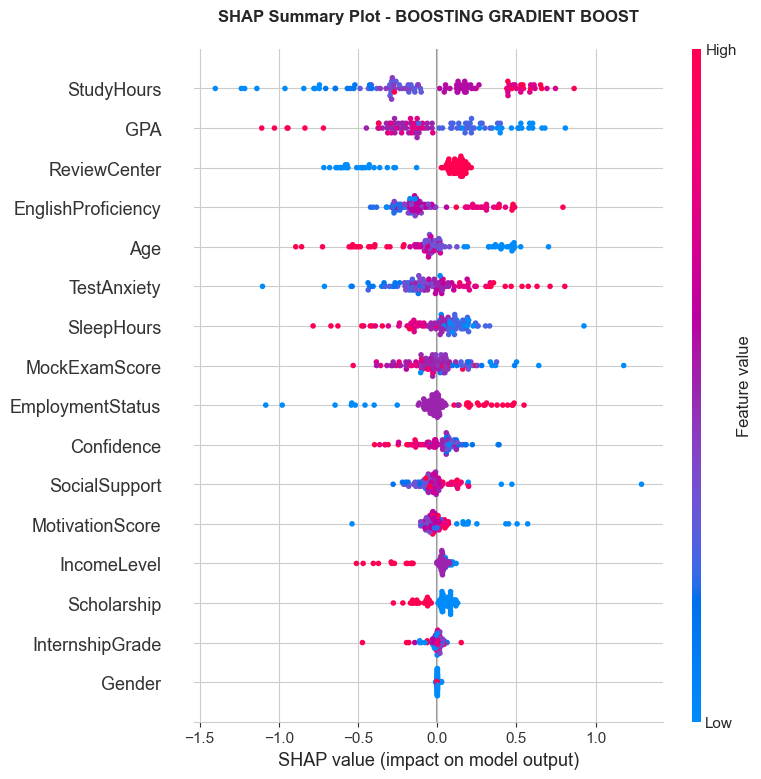


2. SHAP Summary Plot (Bar)
Saved: ../saved_ensemble_models/shap_analysis/boosting_gradient_boost_bar_plot.png


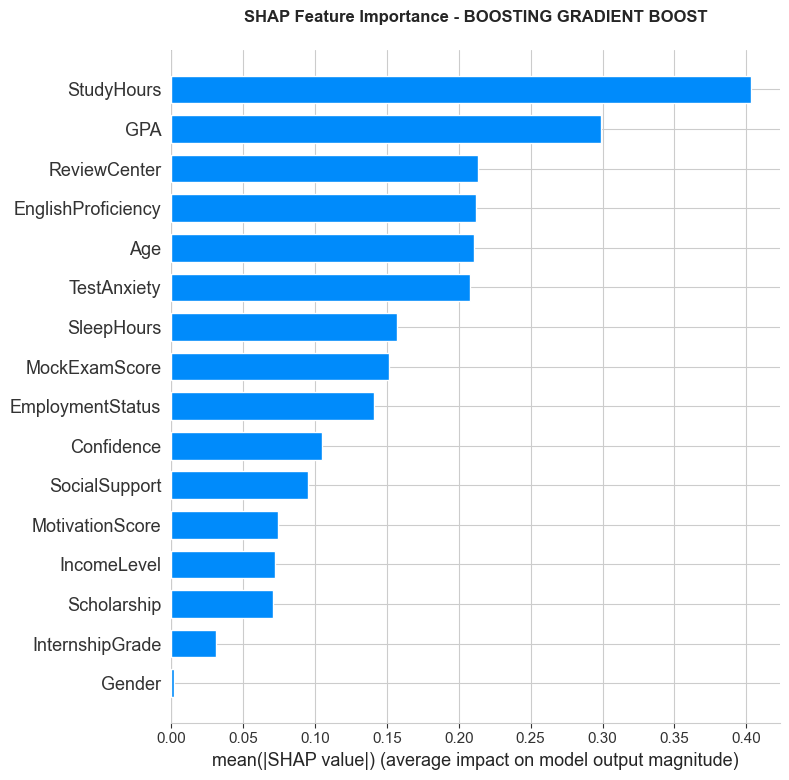


3. SHAP Waterfall Plot (First Prediction)
Saved: ../saved_ensemble_models/shap_analysis/boosting_gradient_boost_waterfall_plot.png


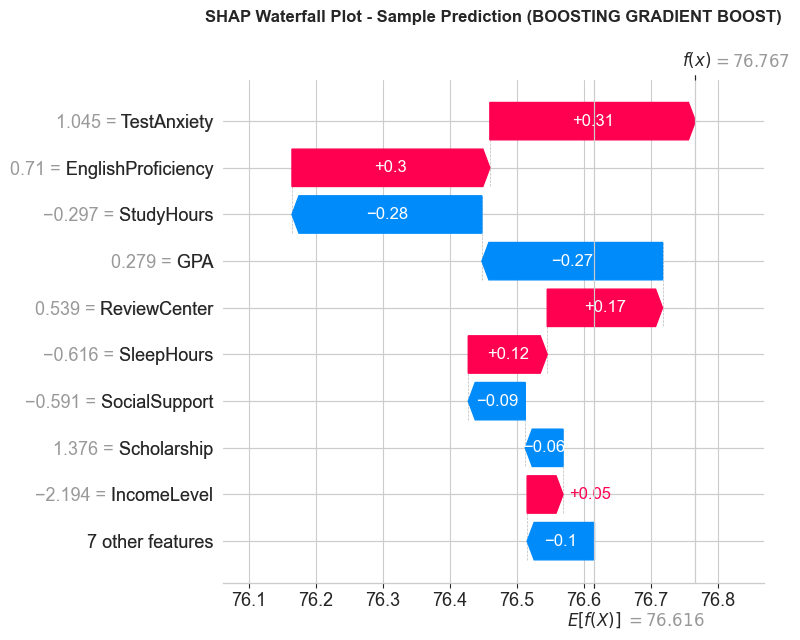


4. SHAP Dependence Plots (Top 3 Features)
Saved: ../saved_ensemble_models/shap_analysis/boosting_gradient_boost_dependence_plots.png


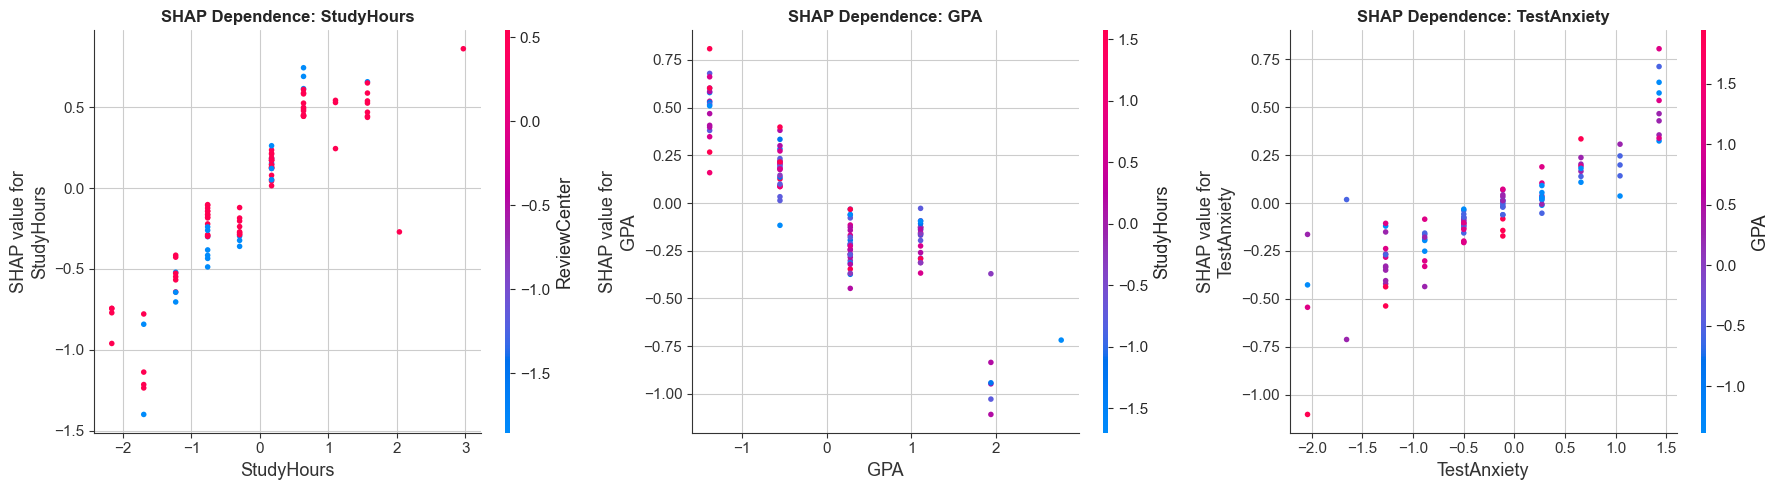


SHAP FORCE PLOTS FOR INDIVIDUAL PREDICTIONS

Force plot for sample 0
Saved: ../saved_ensemble_models/shap_analysis/force_plot_sample_0.png


<Figure size 2000x300 with 0 Axes>

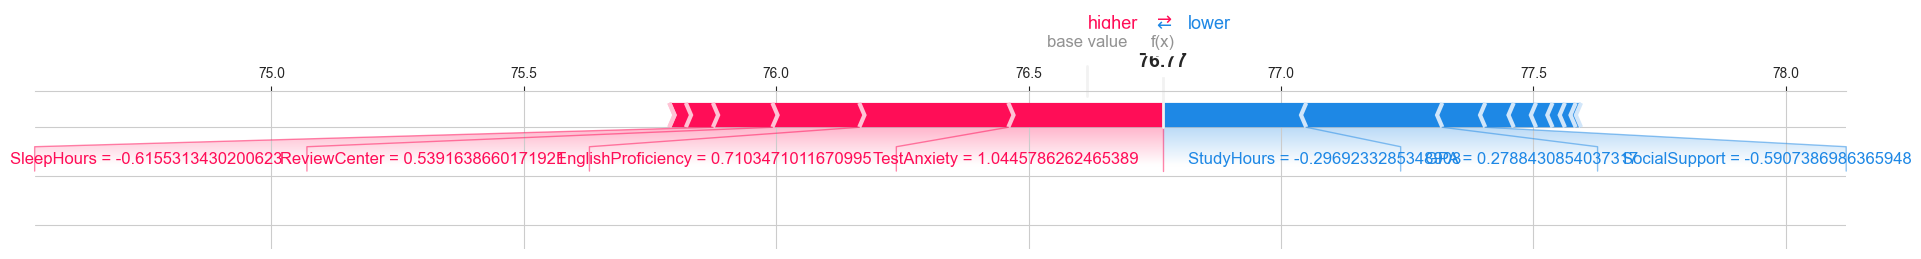


Force plot for sample 1
Saved: ../saved_ensemble_models/shap_analysis/force_plot_sample_1.png


<Figure size 2000x300 with 0 Axes>

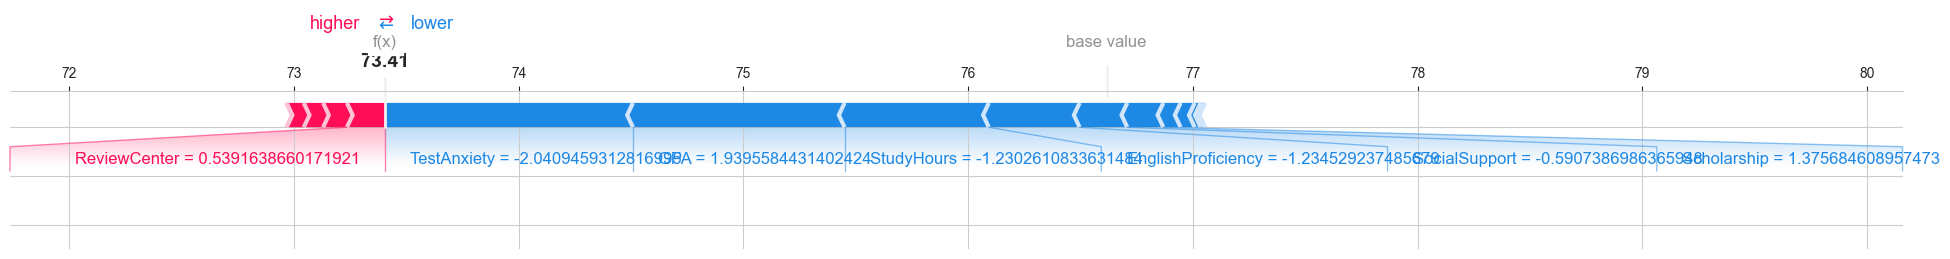


Force plot for sample 2
Saved: ../saved_ensemble_models/shap_analysis/force_plot_sample_2.png


<Figure size 2000x300 with 0 Axes>

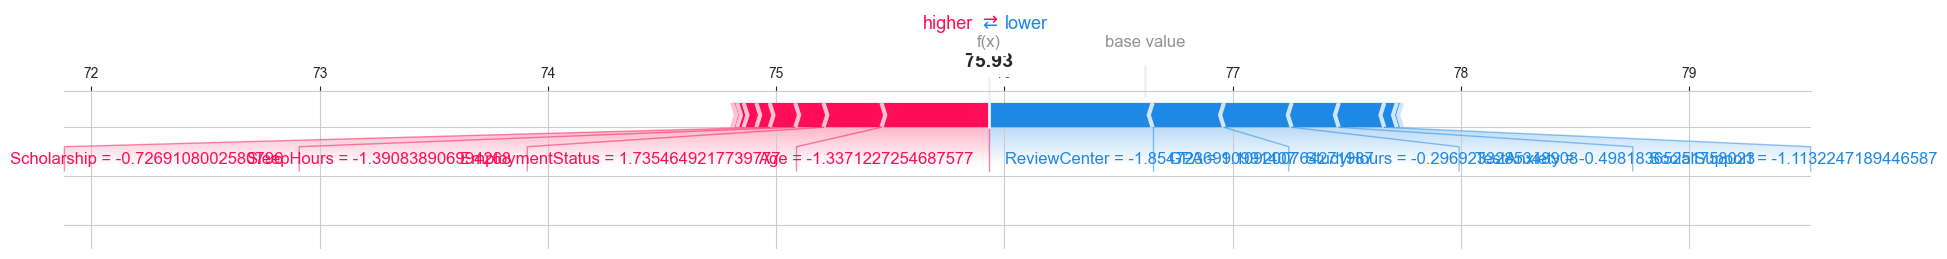


COMPARING ENSEMBLE vs BASE MODELS SHAP IMPORTANCE

Base models SHAP analysis not found. Run base models SHAP analysis first.

SHAP ANALYSIS COMPLETE

SHAP importance data saved to: ../saved_ensemble_models/shap_analysis/

Files created:
   bagging_neural_network_shap_importance.csv
   bagging_random_forest_shap_importance.csv
   boosting_gradient_boost_shap_importance.csv
   stacking_neural_only_shap_importance.csv
   stacking_neural_ridge_shap_importance.csv
   stacking_neural_ridge_neural_final_shap_importance.csv
   stacking_neural_ridge_ridge_final_shap_importance.csv
   combined_shap_importance.csv
   ensemble_models_shap_comparison.png
   boosting_gradient_boost_summary_plot.png
   boosting_gradient_boost_bar_plot.png
   boosting_gradient_boost_waterfall_plot.png
   boosting_gradient_boost_dependence_plots.png
   force_plot_sample_0.png, force_plot_sample_1.png, force_plot_sample_2.png
   ensemble_vs_base_shap_comparison.png
   ensemble_vs_base_shap_comparison.csv


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import shap
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("All libraries imported successfully")
print("SHAP version:", shap.__version__)

# Load preprocessed data
X_train = np.load('../regression_processed_data/X_train.npy')
X_test = np.load('../regression_processed_data/X_test.npy')
y_train = np.load('../regression_processed_data/y_train.npy')
y_test = np.load('../regression_processed_data/y_test.npy')
feature_names = json.load(open('../regression_processed_data/feature_names.json'))

print(f"Data Loaded:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Feature names: {len(feature_names)}")

# Dynamically load all available ensemble models
ensemble_models = {}
model_dir = '../saved_ensemble_models'

# Check if directory exists
if not os.path.exists(model_dir):
    print(f"Error: Directory {model_dir} does not exist")
    sys.exit(1)

# Get all .pkl files in the directory
available_models = [f.replace('_ensemble.pkl', '') for f in os.listdir(model_dir) 
                   if f.endswith('_ensemble.pkl')]

if not available_models:
    print(f"Error: No ensemble models found in {model_dir}")
    sys.exit(1)

print(f"\nFound {len(available_models)} ensemble models:")
for model_name in available_models:
    print(f"   - {model_name}")

# Load all available models
for model_name in available_models:
    model_path = f'{model_dir}/{model_name}_ensemble.pkl'
    try:
        ensemble_models[model_name] = joblib.load(model_path)
        print(f"Loaded: {model_name.replace('_', ' ').upper()}")
    except Exception as e:
        print(f"Error loading {model_name}: {str(e)}")

if not ensemble_models:
    print("Error: No models were successfully loaded")
    sys.exit(1)

print("\n" + "=" * 70)
print("SHAP (SHAPLEY VALUES) FEATURE IMPORTANCE ANALYSIS - ENSEMBLE MODELS")
print("=" * 70)

shap_results = {}

print("\nCalculating SHAP values for all ensemble models...")
print("This may take several minutes...")

for name, model in ensemble_models.items():
    print(f"\n[{name.upper()}] Computing SHAP values...")
    
    try:
        # Determine model type and use appropriate explainer
        if 'random_forest' in name.lower() or 'gradient_boost' in name.lower():
            # Tree-based models
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
        
        elif 'neural' in name.lower() or 'stacking' in name.lower():
            # Neural network or stacking models - use KernelExplainer
            background = shap.sample(X_train, 100)
            explainer = shap.KernelExplainer(model.predict, background)
            shap_values = explainer.shap_values(X_test[:100])
        
        else:
            # Default to KernelExplainer for unknown model types
            background = shap.sample(X_train, 100)
            explainer = shap.KernelExplainer(model.predict, background)
            shap_values = explainer.shap_values(X_test[:100])
        
        shap_results[name] = {
            'explainer': explainer,
            'shap_values': shap_values,
            'feature_importance': np.abs(shap_values).mean(axis=0)
        }
        
        print(f"   SHAP computation complete for {name.upper()}")
    
    except Exception as e:
        print(f"   Error computing SHAP for {name}: {str(e)}")
        continue

if not shap_results:
    print("Error: No SHAP values were computed successfully")
    sys.exit(1)

print("\n" + "=" * 70)
print("SHAP FEATURE IMPORTANCE RANKINGS")
print("=" * 70)

shap_importance_df_list = []

for name, shap_data in shap_results.items():
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_data['feature_importance']
    }).sort_values('SHAP_Importance', ascending=False)
    
    shap_importance_df_list.append(importance_df)
    
    print(f"\n{name.replace('_', ' ').upper()} - Top 10 Features by SHAP:")
    print(f"{'Rank':<6}{'Feature':<25}{'SHAP Importance':<20}")
    print("-" * 51)
    
    for i, (idx, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"{i:<6}{row['Feature']:<25}{row['SHAP_Importance']:<20.6f}")

# Combine SHAP importance across all models
combined_shap = pd.DataFrame({
    'Feature': feature_names
})

for name, shap_data in shap_results.items():
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        f'{name}_shap': shap_data['feature_importance']
    })
    combined_shap = combined_shap.merge(importance_df, on='Feature')

shap_cols = [col for col in combined_shap.columns if col.endswith('_shap')]
combined_shap['avg_shap'] = combined_shap[shap_cols].mean(axis=1)
combined_shap = combined_shap.sort_values('avg_shap', ascending=False)

print("\n" + "=" * 70)
print("CONSENSUS SHAP FEATURE IMPORTANCE (Averaged Across All Ensemble Models)")
print("=" * 70)

print(f"\n{'Rank':<6}{'Feature':<25}{'Average SHAP':<20}")
print("-" * 51)

for i, (idx, row) in enumerate(combined_shap.head(12).iterrows(), 1):
    print(f"{i:<6}{row['Feature']:<25}{row['avg_shap']:<20.6f}")

print("\n" + "=" * 70)
print("SHAP VISUALIZATIONS")
print("=" * 70)

# Create output directory
os.makedirs('../saved_ensemble_models/shap_analysis', exist_ok=True)

# Calculate grid size for subplots
num_models = len(shap_results)
num_cols = 2
num_rows = (num_models + 1 + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
axes = axes.flatten()

colors = ['#f59e0b', '#10b981', '#8b5cf6', '#ef4444', '#3b82f6', '#ec4899', '#14b8a6', '#f97316']

for idx, (name, shap_data) in enumerate(shap_results.items()):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_data['feature_importance']
    }).sort_values('SHAP_Importance', ascending=False).head(10)
    
    axes[idx].barh(importance_df['Feature'], importance_df['SHAP_Importance'],
                   color=colors[idx % len(colors)], edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('Mean |SHAP Value|', fontweight='bold')
    axes[idx].set_title(f'{name.replace("_", " ").upper()} - SHAP Feature Importance', fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

# Add consensus plot
axes[num_models].barh(combined_shap.head(12)['Feature'], combined_shap.head(12)['avg_shap'],
             color='mediumpurple', edgecolor='black', alpha=0.7)
axes[num_models].set_xlabel('Average SHAP Importance', fontweight='bold')
axes[num_models].set_title('CONSENSUS - Average SHAP Across All Ensemble Models', fontweight='bold')
axes[num_models].invert_yaxis()
axes[num_models].grid(axis='x', alpha=0.3)

# Hide unused subplots
for idx in range(num_models + 1, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('../saved_ensemble_models/shap_analysis/ensemble_models_shap_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: ../saved_ensemble_models/shap_analysis/ensemble_models_shap_comparison.png")
plt.show()

# Find the best tree-based model for detailed analysis
tree_based_models = {k: v for k, v in shap_results.items() 
                     if 'random_forest' in k.lower() or 'gradient_boost' in k.lower()}

if tree_based_models:
    # Select the first tree-based model or gradient boost if available
    best_model_name = next((k for k in tree_based_models.keys() if 'gradient_boost' in k.lower()), 
                           next(iter(tree_based_models.keys())))
    
    print("\n" + "=" * 70)
    print(f"DETAILED SHAP PLOTS FOR {best_model_name.upper()}")
    print("=" * 70)
    
    best_shap_values = shap_results[best_model_name]['shap_values']
    best_explainer = shap_results[best_model_name]['explainer']
    
    sample_size = min(100, len(best_shap_values))
    
    # Summary plot
    print(f"\n1. SHAP Summary Plot (Feature Impact Distribution)")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(best_shap_values[:sample_size], 
                     X_test[:sample_size], 
                     feature_names=feature_names,
                     show=False)
    plt.title(f'SHAP Summary Plot - {best_model_name.replace("_", " ").upper()}', fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'../saved_ensemble_models/shap_analysis/{best_model_name}_summary_plot.png', dpi=300, bbox_inches='tight')
    print(f"Saved: ../saved_ensemble_models/shap_analysis/{best_model_name}_summary_plot.png")
    plt.show()
    
    # Bar plot
    print(f"\n2. SHAP Summary Plot (Bar)")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(best_shap_values[:sample_size], 
                     X_test[:sample_size], 
                     feature_names=feature_names,
                     plot_type="bar",
                     show=False)
    plt.title(f'SHAP Feature Importance - {best_model_name.replace("_", " ").upper()}', fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'../saved_ensemble_models/shap_analysis/{best_model_name}_bar_plot.png', dpi=300, bbox_inches='tight')
    print(f"Saved: ../saved_ensemble_models/shap_analysis/{best_model_name}_bar_plot.png")
    plt.show()
    
    # Waterfall plot
    print(f"\n3. SHAP Waterfall Plot (First Prediction)")
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(
        shap.Explanation(values=best_shap_values[0],
                        base_values=best_explainer.expected_value,
                        data=X_test[0],
                        feature_names=feature_names),
        show=False
    )
    plt.title(f'SHAP Waterfall Plot - Sample Prediction ({best_model_name.replace("_", " ").upper()})', 
             fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'../saved_ensemble_models/shap_analysis/{best_model_name}_waterfall_plot.png', dpi=300, bbox_inches='tight')
    print(f"Saved: ../saved_ensemble_models/shap_analysis/{best_model_name}_waterfall_plot.png")
    plt.show()
    
    # Dependence plots
    top_features = combined_shap.head(3)['Feature'].tolist()
    
    print(f"\n4. SHAP Dependence Plots (Top 3 Features)")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, feature in enumerate(top_features):
        feature_idx = feature_names.index(feature)
        
        shap.dependence_plot(
            feature_idx,
            best_shap_values[:sample_size],
            X_test[:sample_size],
            feature_names=feature_names,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(f'SHAP Dependence: {feature}', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'../saved_ensemble_models/shap_analysis/{best_model_name}_dependence_plots.png', dpi=300, bbox_inches='tight')
    print(f"Saved: ../saved_ensemble_models/shap_analysis/{best_model_name}_dependence_plots.png")
    plt.show()
    
    # Force plots
    print("\n" + "=" * 70)
    print("SHAP FORCE PLOTS FOR INDIVIDUAL PREDICTIONS")
    print("=" * 70)
    
    sample_indices = [0, 1, 2]
    
    for sample_idx in sample_indices:
        print(f"\nForce plot for sample {sample_idx}")
        plt.figure(figsize=(20, 3))
        
        shap.force_plot(
            best_explainer.expected_value,
            best_shap_values[sample_idx],
            X_test[sample_idx],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        
        plt.tight_layout()
        plt.savefig(f'../saved_ensemble_models/shap_analysis/force_plot_sample_{sample_idx}.png', 
                    dpi=300, bbox_inches='tight')
        print(f"Saved: ../saved_ensemble_models/shap_analysis/force_plot_sample_{sample_idx}.png")
        plt.show()

# Save SHAP importance data
for name, shap_data in shap_results.items():
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_data['feature_importance']
    }).sort_values('SHAP_Importance', ascending=False)
    
    importance_df.to_csv(f'../saved_ensemble_models/shap_analysis/{name}_shap_importance.csv', index=False)

combined_shap.to_csv('../saved_ensemble_models/shap_analysis/combined_shap_importance.csv', index=False)

print("\n" + "=" * 70)
print("COMPARING ENSEMBLE vs BASE MODELS SHAP IMPORTANCE")
print("=" * 70)

try:
    base_combined = pd.read_csv('../saved_base_models/shap_analysis/combined_shap_importance.csv')
    
    comparison_df = pd.merge(
        combined_shap[['Feature', 'avg_shap']].rename(columns={'avg_shap': 'Ensemble_SHAP'}),
        base_combined[['Feature', 'avg_shap']].rename(columns={'avg_shap': 'Base_SHAP'}),
        on='Feature'
    )
    
    comparison_df['SHAP_Difference'] = comparison_df['Ensemble_SHAP'] - comparison_df['Base_SHAP']
    comparison_df = comparison_df.sort_values('Ensemble_SHAP', ascending=False)
    
    print("\nTop 10 Features - Ensemble vs Base Models SHAP Comparison:")
    print(f"\n{'Rank':<6}{'Feature':<20}{'Ensemble':<15}{'Base':<15}{'Difference':<15}")
    print("-" * 71)
    
    for i, (idx, row) in enumerate(comparison_df.head(10).iterrows(), 1):
        print(f"{i:<6}{row['Feature']:<20}{row['Ensemble_SHAP']:<15.6f}{row['Base_SHAP']:<15.6f}{row['SHAP_Difference']:<15.6f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    top_10 = comparison_df.head(10)
    
    x = np.arange(len(top_10))
    width = 0.35
    
    axes[0].barh(x - width/2, top_10['Base_SHAP'], width, 
                label='Base Models', color='skyblue', alpha=0.8)
    axes[0].barh(x + width/2, top_10['Ensemble_SHAP'], width, 
                label='Ensemble Models', color='orange', alpha=0.8)
    
    axes[0].set_yticks(x)
    axes[0].set_yticklabels(top_10['Feature'])
    axes[0].set_xlabel('Average SHAP Importance', fontweight='bold')
    axes[0].set_title('Top 10 Features: Ensemble vs Base Models', fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    colors_diff = ['red' if x < 0 else 'green' for x in top_10['SHAP_Difference']]
    axes[1].barh(top_10['Feature'], top_10['SHAP_Difference'], 
                color=colors_diff, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('SHAP Difference (Ensemble - Base)', fontweight='bold')
    axes[1].set_title('Feature Importance Change: Ensemble vs Base', fontweight='bold')
    axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('../saved_ensemble_models/shap_analysis/ensemble_vs_base_shap_comparison.png', 
                dpi=300, bbox_inches='tight')
    print("\nSaved: ../saved_ensemble_models/shap_analysis/ensemble_vs_base_shap_comparison.png")
    plt.show()
    
    comparison_df.to_csv('../saved_ensemble_models/shap_analysis/ensemble_vs_base_shap_comparison.csv', index=False)
    print("Saved: ../saved_ensemble_models/shap_analysis/ensemble_vs_base_shap_comparison.csv")
    
except FileNotFoundError:
    print("\nBase models SHAP analysis not found. Run base models SHAP analysis first.")

print("\n" + "=" * 70)
print("SHAP ANALYSIS COMPLETE")
print("=" * 70)
print(f"\nSHAP importance data saved to: ../saved_ensemble_models/shap_analysis/")
print(f"\nFiles created:")
for name in shap_results.keys():
    print(f"   {name}_shap_importance.csv")
print(f"   combined_shap_importance.csv")
print(f"   ensemble_models_shap_comparison.png")
if tree_based_models:
    print(f"   {best_model_name}_summary_plot.png")
    print(f"   {best_model_name}_bar_plot.png")
    print(f"   {best_model_name}_waterfall_plot.png")
    print(f"   {best_model_name}_dependence_plots.png")
    print(f"   force_plot_sample_0.png, force_plot_sample_1.png, force_plot_sample_2.png")
print(f"   ensemble_vs_base_shap_comparison.png")
print(f"   ensemble_vs_base_shap_comparison.csv")